In [1]:
import pandas as pd

# Load the data
file_path = '/root/DATA/filtered_merged_data.csv'
data = pd.read_csv(file_path, low_memory=False)

# Data type conversion
data['intime_x'] = pd.to_datetime(data['intime_x'], errors='coerce')  # Admission time
data['outtime_x'] = pd.to_datetime(data['outtime_x'], errors='coerce')  # Discharge time
data['age_years'] = pd.to_numeric(data['age_years'], errors='coerce')  # Age
data['expire_flag'] = pd.to_numeric(data['expire_flag'], errors='coerce')  # Survival status

# Basic statistics
missing_summary = data.isnull().sum() / len(data) * 100
print("Missing values percentage for each column:")
print(missing_summary)

# Demographics
median_age = data['age_years'].median()
iqr_age = data['age_years'].quantile([0.25, 0.75]).tolist()
print(f"\nMedian Age: {median_age}")
print(f"IQR Age: {iqr_age}")

# Length of stay statistics
median_los = data['los_x'].median()
print(f"\nMedian Length of Stay (LOS): {median_los} days")

# Admission type distribution
admission_type_distribution = data['admission_type'].value_counts(normalize=True) * 100
print("\nAdmission Type Distribution:")
print(admission_type_distribution)

# Admission location distribution
admission_location_distribution = data['admission_location'].value_counts(normalize=True) * 100
print("\nAdmission Location Distribution:")
print(admission_location_distribution)

# Diagnosis distribution
diagnosis_distribution = data['diagnosis'].value_counts(normalize=True) * 100
print("\nDiagnosis Distribution:")
print(diagnosis_distribution)

# Laboratory data statistics
lab_columns = ['lactate', 'bloodureanitrogen', 'hemoglobin']
lab_stats = {}
for col in lab_columns:
    lab_stats[col] = {
        "Median": data[col].median(),
        "IQR": data[col].quantile([0.25, 0.75]).tolist()
    }
print("\nLaboratory Data Statistics:")
print(pd.DataFrame(lab_stats))

# Weekend admission analysis
data['is_weekend_admission'] = data['intime_x'].dt.weekday >= 5  # Mark weekend admissions
weekend_distribution = data['is_weekend_admission'].value_counts(normalize=True) * 100
print("\nWeekend Admission Distribution:")
print(weekend_distribution)


Missing values percentage for each column:
subject_id_x               0.000000
row_id_x                   0.000000
hadm_id_x                  0.000000
icustay_id                 0.000000
dbsource                   0.000000
                            ...    
icu_expire_flag            0.000000
hospital_expire_flag_y    26.221404
dod                       47.643044
expire_flag                0.000000
ttd_days                  47.643044
Length: 82, dtype: float64

Median Age: 64.0
IQR Age: [51.0, 77.0]

Median Length of Stay (LOS): 4.557 days

Admission Type Distribution:
admission_type
EMERGENCY    89.044450
ELECTIVE      8.023961
URGENT        2.931589
Name: proportion, dtype: float64

Admission Location Distribution:
admission_location
EMERGENCY ROOM ADMIT         45.284046
TRANSFER FROM HOSP/EXTRAM    26.424246
CLINIC REFERRAL/PREMATURE    17.055460
PHYS REFERRAL/NORMAL DELI    10.331917
TRANSFER FROM SKILLED NUR     0.818988
TRANSFER FROM OTHER HEALT     0.075849
** INFO NOT AVAILAB

In [3]:
categorical_vars = [col for col in data.columns if data[col].dtype == 'object' or data[col].nunique() < 10]
print("\nCategorical Variables:")
print(categorical_vars)
continuous_vars = [col for col in data.columns if data[col].dtype in ['int64', 'float64'] and data[col].nunique() >= 10]
print("\nContinuous Variables:")
print(continuous_vars)



Categorical Variables:
['dbsource', 'first_careunit', 'last_careunit', 'admittime_x', 'dischtime_x', 'deathtime', 'admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis', 'hospital_expire_flag_x', 'has_chartevents_data', 'dy', 'charttime', 'chartdate', 'org_name', 'positiveculture', 'ab_name', 'antibioticresistance', 'gcseyes', 'gcsmotor', 'gcsverbal', 'endotrachflag', 'dob', 'admittime_y', 'dischtime_y', 'intime_y', 'outtime_y', 'hosp_deathtime', 'icu_expire_flag', 'hospital_expire_flag_y', 'dod', 'expire_flag', 'is_weekend_admission']

Continuous Variables:
['subject_id_x', 'row_id_x', 'hadm_id_x', 'icustay_id', 'first_wardid', 'last_wardid', 'los_x', 'row_id_y', 'subject_id_y', 'hadm_id_y', 'hr_x', 'hr_y', 'gcs', 'hr', 'neutrophil', 'creactiveprotein', 'whitebloodcell', 'partialpressureo2', 'bicarbonate', 'lactate', 'troponin', 'bloodureanitrogen', 'creatinine', 'alaninet

In [5]:
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(data['admission_type'], data['is_weekend_admission'])

# Perform Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square test result for admission_type: p-value = {p}")



Chi-square test result for admission_type: p-value = 1.595178290691447e-197


In [6]:
from scipy.stats import mannwhitneyu

# Group data by weekend and weekday admissions
weekend_group = data.loc[data['is_weekend_admission'], 'age_years'].dropna()
weekday_group = data.loc[~data['is_weekend_admission'], 'age_years'].dropna()

# Perform Mann-Whitney U test
stat, p_value = mannwhitneyu(weekend_group, weekday_group, alternative='two-sided')
print(f"Mann-Whitney U test for age_years: p-value = {p_value}")


Mann-Whitney U test for age_years: p-value = 6.184113192562729e-44


In [7]:
contingency_table = pd.crosstab(data['admission_type'], data['is_weekend_admission'], normalize='columns') * 100
print("\nPercentage Distribution of Admission Type by Weekend Admission:")
print(contingency_table)



Percentage Distribution of Admission Type by Weekend Admission:
is_weekend_admission      False      True 
admission_type                            
ELECTIVE               5.579546   3.318338
EMERGENCY             90.187730  90.740937
URGENT                 4.232724   5.940725


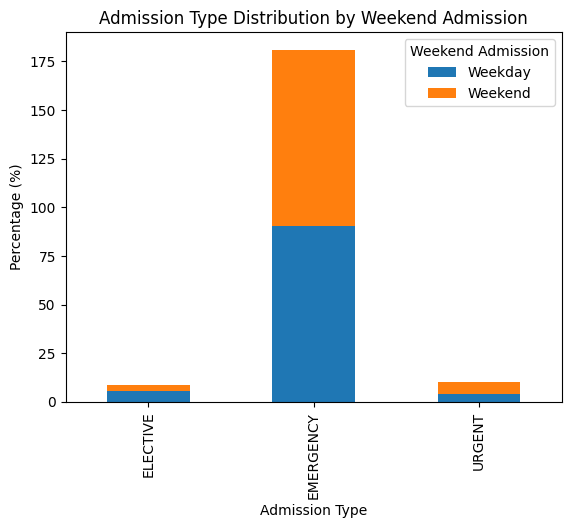

In [8]:
import matplotlib.pyplot as plt

# Plot stacked bar chart
contingency_table.plot(kind='bar', stacked=True)
plt.title('Admission Type Distribution by Weekend Admission')
plt.xlabel('Admission Type')
plt.ylabel('Count')
plt.legend(title='Weekend Admission', labels=['Weekday', 'Weekend'])
plt.show()



In [9]:
# Age distribution for weekend and weekday groups
weekend_age = data.loc[data['is_weekend_admission'], 'age_years']
weekday_age = data.loc[~data['is_weekend_admission'], 'age_years']

# Calculate median and interquartile range (IQR)
weekend_stats = weekend_age.describe(percentiles=[0.25, 0.75])
weekday_stats = weekday_age.describe(percentiles=[0.25, 0.75])

print("\nWeekend Age Distribution:")
print(weekend_stats[['50%', '25%', '75%']].rename({'50%': 'Median', '25%': 'Q1', '75%': 'Q3'}))

print("\nWeekday Age Distribution:")
print(weekday_stats[['50%', '25%', '75%']].rename({'50%': 'Median', '25%': 'Q1', '75%': 'Q3'}))



Weekend Age Distribution:
Median    65.0
Q1        51.0
Q3        78.0
Name: age_years, dtype: float64

Weekday Age Distribution:
Median    63.0
Q1        50.0
Q3        76.0
Name: age_years, dtype: float64


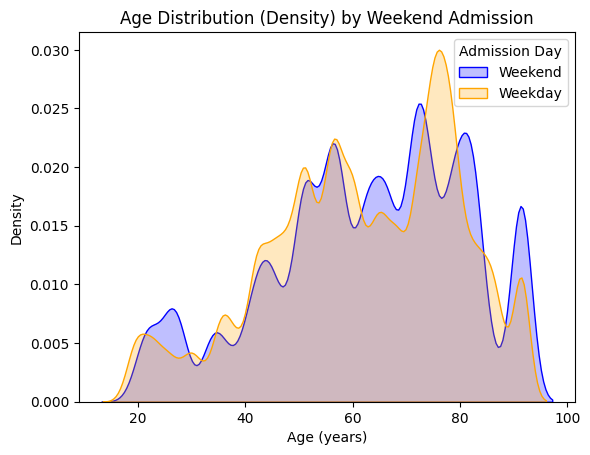

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# KDE plot: Age distribution density for weekend and weekday admissions
sns.kdeplot(weekend_age, fill=True, label='Weekend', color='blue')
sns.kdeplot(weekday_age, fill=True, label='Weekday', color='orange')
plt.title('Age Distribution (Density) by Weekend Admission')
plt.xlabel('Age (years)')
plt.legend(title='Admission Day')
plt.show()



In [12]:
# Overall mortality rate
overall_mortality_rate = data['expire_flag'].mean() * 100
print(f"Overall Mortality Rate: {overall_mortality_rate:.2f}%")

# Mortality rate for weekend vs. weekday admissions
mortality_by_weekend = data.groupby('is_weekend_admission')['expire_flag'].mean() * 100
print("\nMortality Rate by Weekend Admission:")
print(mortality_by_weekend)


Overall Mortality Rate: 66.06%

Mortality Rate by Weekend Admission:
is_weekend_admission
False    68.095022
True     60.713152
Name: expire_flag, dtype: float64


In [13]:
# Calculate mortality rate by admission type
mortality_by_admission_type = data.groupby('admission_type')['expire_flag'].mean() * 100
print("\nMortality Rate by Admission Type:")
print(mortality_by_admission_type)



Mortality Rate by Admission Type:
admission_type
ELECTIVE     67.088421
EMERGENCY    65.817109
URGENT       69.658915
Name: expire_flag, dtype: float64


In [18]:
# Calculate mortality rate by age group
mortality_by_age_group = data.groupby('age_group', observed=False)['expire_flag'].mean() * 100
print("\nMortality Rate by Age Group:")
print(mortality_by_age_group)



Mortality Rate by Age Group:
age_group
<40      29.269821
40-60    51.141694
60-80    80.046119
>80      92.179602
Name: expire_flag, dtype: float64


In [8]:
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportion_confint

# Function to calculate admission statistics
def calculate_admission_statistics(data, group_col, variables):
    results = []
    
    # Calculate total row for all data
    total_data = data.groupby(group_col).size().reset_index(name='count')
    for index, row in total_data.iterrows():
        results.append({
            'Category': 'Total',
            'Level': 'Total',
            'Group': 'Weekday' if row[group_col] == False else 'Weekend',
            'N': int(row['count']),
            '% (group)': f"{row['count'] / total_data['count'].sum() * 100:.2f}%"
        })
    
    # Calculate statistics for each variable
    for var in variables:
        for level in data[var].dropna().unique():  # Iterate over levels of each categorical variable
            level_data = data[data[var] == level]
            for group in data[group_col].unique():  # Iterate over Weekday and Weekend groups
                group_data = level_data[level_data[group_col] == group]
                n = len(group_data)
                total_n = len(data[data[group_col] == group])  # Total count for the group
                results.append({
                    'Category': var,
                    'Level': level,
                    'Group': 'Weekday' if group == False else 'Weekend',
                    'N': n,
                    '% (group)': f"{n / total_n * 100:.2f}%" if total_n > 0 else "0.00%"
                })
    
    return pd.DataFrame(results)

# Create age groups
data['age_years_group'] = pd.cut(data['age_years'], bins=[0, 19, 39, 59, 79, 120], labels=['0–19', '20–39', '40–59', '60–79', '>80'])

# Define the categorical variables (original + 4 additional)
categorical_vars = [
    'admission_type', 
    'admission_location', 
    'age_years_group', 
    'first_careunit',  # New
    'last_careunit'

]

# Generate the table
admission_table = calculate_admission_statistics(data, 'is_weekend_admission', categorical_vars)

# Add "Total" as the first row
admission_table = pd.concat([
    admission_table[admission_table['Category'] == 'Total'],
    admission_table[admission_table['Category'] != 'Total']
])

# Print the results
print(admission_table)

# Optionally save to Excel
admission_table.to_excel('admission_table_with_total_first_row.xlsx', index=False)



              Category                      Level    Group        N % (group)
0                Total                      Total  Weekday  2139505    72.80%
1                Total                      Total  Weekend   799243    27.20%
2       admission_type                  EMERGENCY  Weekday  1896104    88.62%
3       admission_type                  EMERGENCY  Weekend   720688    90.17%
4       admission_type                   ELECTIVE  Weekday   199293     9.31%
5       admission_type                   ELECTIVE  Weekend    36511     4.57%
6       admission_type                     URGENT  Weekday    44108     2.06%
7       admission_type                     URGENT  Weekend    42044     5.26%
8   admission_location       EMERGENCY ROOM ADMIT  Weekday   922160    43.10%
9   admission_location       EMERGENCY ROOM ADMIT  Weekend   408624    51.13%
10  admission_location  TRANSFER FROM HOSP/EXTRAM  Weekday   582112    27.21%
11  admission_location  TRANSFER FROM HOSP/EXTRAM  Weekend   194

In [24]:
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportion_confint

# Function to calculate group statistics and 95% confidence intervals
def calculate_group_mortality(data, group_col, outcome_col, variables):
    results = []
    
    # Calculate total row for all data
    total_data = data.groupby(group_col)[outcome_col].agg(['count', 'mean']).reset_index()
    total_data['ci_low'], total_data['ci_high'] = proportion_confint(
        count=(total_data['count'] * total_data['mean']).astype(int),
        nobs=total_data['count'],
        method='wilson'
    )
    for index, row in total_data.iterrows():
        results.append({
            'Category': 'Total',
            'Level': 'Total',
            'Group': 'Weekday' if row[group_col] == False else 'Weekend',
            'N': int(row['count']),
            '% (group)': f"{row['mean'] * 100:.2f} ({row['ci_low'] * 100:.2f}–{row['ci_high'] * 100:.2f})"
        })
    
    # Calculate statistics for each variable
    for var in variables:
        for level in data[var].dropna().unique():  # Iterate over levels of each categorical variable
            level_data = data[data[var] == level]
            for group in data[group_col].unique():  # Iterate over Weekday and Weekend groups
                group_data = level_data[level_data[group_col] == group]
                
                n = len(group_data)
                mortality_rate = group_data[outcome_col].mean() * 100 if n > 0 else 0
                ci_low, ci_high = proportion_confint(
                    count=group_data[outcome_col].sum(),
                    nobs=n,
                    method='wilson'
                ) if n > 0 else (0, 0)
                ci_low, ci_high = ci_low * 100, ci_high * 100
                
                results.append({
                    'Category': var,
                    'Level': level,
                    'Group': 'Weekday' if group == False else 'Weekend',
                    'N': n,
                    '% (group)': f"{mortality_rate:.2f} ({ci_low:.2f}–{ci_high:.2f})"
                })
    
    return pd.DataFrame(results)

# Example variables
categorical_vars = ['admission_type', 'admission_location']
data['age_years_group'] = pd.cut(data['age_years'], bins=[0, 19, 39, 59, 79, 120], labels=['0–19', '20–39', '40–59', '60–79', '>80'])

# Generate the table
selected_vars = categorical_vars + ['age_years_group']
mortality_table = calculate_group_mortality(data, 'is_weekend_admission', 'expire_flag', selected_vars)

# Add "Total" as the first row
mortality_table = pd.concat([
    mortality_table[mortality_table['Category'] == 'Total'],
    mortality_table[mortality_table['Category'] != 'Total']
])

# Print the results
print(mortality_table)

# Optionally save to Excel
mortality_table.to_excel('mortality_table_with_total_first_row.xlsx', index=False)

              Category                      Level    Group        N  \
0                Total                      Total  Weekday  2139505   
1                Total                      Total  Weekend   799243   
2       admission_type                  EMERGENCY  Weekday  1896104   
3       admission_type                  EMERGENCY  Weekend   720688   
4       admission_type                   ELECTIVE  Weekday   199293   
5       admission_type                   ELECTIVE  Weekend    36511   
6       admission_type                     URGENT  Weekday    44108   
7       admission_type                     URGENT  Weekend    42044   
8   admission_location       EMERGENCY ROOM ADMIT  Weekday   922160   
9   admission_location       EMERGENCY ROOM ADMIT  Weekend   408624   
10  admission_location  TRANSFER FROM HOSP/EXTRAM  Weekday   582112   
11  admission_location  TRANSFER FROM HOSP/EXTRAM  Weekend   194430   
12  admission_location  CLINIC REFERRAL/PREMATURE  Weekday   370230   
13  ad

In [9]:
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportion_confint

# Function to calculate group statistics and 95% confidence intervals
def calculate_group_mortality(data, group_col, outcome_col, variables):
    results = []
    
    # Calculate total row for all data
    total_data = data.groupby(group_col)[outcome_col].agg(['count', 'mean']).reset_index()
    total_data['ci_low'], total_data['ci_high'] = proportion_confint(
        count=(total_data['count'] * total_data['mean']).astype(int),
        nobs=total_data['count'],
        method='wilson'
    )
    for index, row in total_data.iterrows():
        results.append({
            'Category': 'Total',
            'Level': 'Total',
            'Group': 'Weekday' if row[group_col] == False else 'Weekend',
            'N': int(row['count']),
            '% (group)': f"{row['mean'] * 100:.2f} ({row['ci_low'] * 100:.2f}–{row['ci_high'] * 100:.2f})"
        })
    
    # Calculate statistics for each variable
    for var in variables:
        for level in data[var].dropna().unique():  # Iterate over levels of each categorical variable
            level_data = data[data[var] == level]
            for group in data[group_col].unique():  # Iterate over Weekday and Weekend groups
                group_data = level_data[level_data[group_col] == group]
                
                n = len(group_data)
                mortality_rate = group_data[outcome_col].mean() * 100 if n > 0 else 0
                ci_low, ci_high = proportion_confint(
                    count=group_data[outcome_col].sum(),
                    nobs=n,
                    method='wilson'
                ) if n > 0 else (0, 0)
                ci_low, ci_high = ci_low * 100, ci_high * 100
                
                results.append({
                    'Category': var,
                    'Level': level,
                    'Group': 'Weekday' if group == False else 'Weekend',
                    'N': n,
                    '% (group)': f"{mortality_rate:.2f} ({ci_low:.2f}–{ci_high:.2f})"
                })
    
    return pd.DataFrame(results)

# Define the categorical variables
categorical_vars = ['first_careunit', 'last_careunit']

# Generate the table
mortality_table = calculate_group_mortality(data, 'is_weekend_admission', 'expire_flag', categorical_vars)

# Add "Total" as the first row
mortality_table = pd.concat([
    mortality_table[mortality_table['Category'] == 'Total'],
    mortality_table[mortality_table['Category'] != 'Total']
])

# Print the results
print(mortality_table)

# Optionally save to Excel
mortality_table.to_excel('mortality_table_first_last_careunit.xlsx', index=False)


          Category  Level    Group        N            % (group)
0            Total  Total  Weekday  2139505  51.64 (51.58–51.71)
1            Total  Total  Weekend   799243  54.26 (54.16–54.37)
2   first_careunit   MICU  Weekday   942055  59.62 (59.52–59.72)
3   first_careunit   MICU  Weekend   355295  59.01 (58.85–59.17)
4   first_careunit  TSICU  Weekday   310068  40.67 (40.50–40.85)
5   first_careunit  TSICU  Weekend   135755  48.21 (47.95–48.48)
6   first_careunit    CCU  Weekday   242386  59.68 (59.48–59.87)
7   first_careunit    CCU  Weekend    92596  49.63 (49.30–49.95)
8   first_careunit   SICU  Weekday   416167  47.81 (47.66–47.97)
9   first_careunit   SICU  Weekend   193848  51.69 (51.47–51.91)
10  first_careunit   CSRU  Weekday   228829  32.14 (31.95–32.33)
11  first_careunit   CSRU  Weekend    21749  57.24 (56.59–57.90)
12   last_careunit   MICU  Weekday   941465  60.20 (60.10–60.30)
13   last_careunit   MICU  Weekend   352819  58.75 (58.59–58.91)
14   last_careunit  TSICU

In [10]:
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportion_confint

# Function to calculate group statistics and 95% confidence intervals
def calculate_group_mortality(data, group_col, outcome_col, variables):
    results = []
    
    # Calculate total row for all data
    total_data = data.groupby(group_col)[outcome_col].agg(['count', 'mean']).reset_index()
    total_data['ci_low'], total_data['ci_high'] = proportion_confint(
        count=(total_data['count'] * total_data['mean']).astype(int),
        nobs=total_data['count'],
        method='wilson'
    )
    for index, row in total_data.iterrows():
        results.append({
            'Category': 'Total',
            'Level': 'Total',
            'Group': 'Weekday' if row[group_col] == False else 'Weekend',
            'N': int(row['count']),
            '% (group)': f"{row['mean'] * 100:.2f} ({row['ci_low'] * 100:.2f}–{row['ci_high'] * 100:.2f})"
        })
    
    # Calculate statistics for each variable
    for var in variables:
        for level in data[var].dropna().unique():  # Iterate over levels of each categorical variable
            level_data = data[data[var] == level]
            for group in data[group_col].unique():  # Iterate over Weekday and Weekend groups
                group_data = level_data[level_data[group_col] == group]
                
                n = len(group_data)
                mortality_rate = group_data[outcome_col].mean() * 100 if n > 0 else 0
                ci_low, ci_high = proportion_confint(
                    count=group_data[outcome_col].sum(),
                    nobs=n,
                    method='wilson'
                ) if n > 0 else (0, 0)
                ci_low, ci_high = ci_low * 100, ci_high * 100
                
                results.append({
                    'Category': var,
                    'Level': level,
                    'Group': 'Weekday' if group == False else 'Weekend',
                    'N': n,
                    '% (group)': f"{mortality_rate:.2f} ({ci_low:.2f}–{ci_high:.2f})"
                })
    
    return pd.DataFrame(results)

# Define the categorical variables
categorical_vars = ['insurance']

# Generate the table
mortality_table = calculate_group_mortality(data, 'is_weekend_admission', 'expire_flag', categorical_vars)

# Add "Total" as the first row
mortality_table = pd.concat([
    mortality_table[mortality_table['Category'] == 'Total'],
    mortality_table[mortality_table['Category'] != 'Total']
])

# Print the results
print(mortality_table)

# Optionally save to Excel
mortality_table.to_excel('mortality_table_first_last_careunit.xlsx', index=False)


     Category       Level    Group        N            % (group)
0       Total       Total  Weekday  2139505  51.64 (51.58–51.71)
1       Total       Total  Weekend   799243  54.26 (54.16–54.37)
2   insurance    Medicare  Weekday  1162221  64.36 (64.27–64.45)
3   insurance    Medicare  Weekend   425452  70.45 (70.32–70.59)
4   insurance     Private  Weekday   676634  35.99 (35.88–36.11)
5   insurance     Private  Weekend   246910  34.34 (34.16–34.53)
6   insurance    Medicaid  Weekday   205280  41.91 (41.70–42.12)
7   insurance    Medicaid  Weekend    79393  41.27 (40.93–41.61)
8   insurance    Self Pay  Weekday    25452  28.05 (27.50–28.61)
9   insurance    Self Pay  Weekend    20136  61.20 (60.52–61.87)
10  insurance  Government  Weekday    69918  28.93 (28.59–29.27)
11  insurance  Government  Weekend    27352  14.87 (14.45–15.29)


# Study Results

In this study, the median age of patients was **64 years** (IQR: **51–77 years**), with a predominance of middle-aged and elderly individuals. The median length of stay (LOS) was **4.56 days**, and the majority of patients were admitted through the **emergency department (45.28%)**, with emergency admissions accounting for the largest proportion (**89.04%**) and elective admissions being relatively low (**8.02%**). The primary diagnoses included **sepsis (4.62%)**, **pneumonia (3.50%)**, and **intracranial hemorrhage (2.52%)**. Laboratory data revealed that some patients had renal function abnormalities (median blood urea nitrogen: **22.0**, IQR: **14.0–38.0**) and anemia (median hemoglobin: **10.5**, IQR: **9.3–12.0**). **Weekend admissions accounted for 27.20%** of all cases, significantly lower than **72.80%** for weekday admissions, which could reflect differences in resource allocation and patient behavior patterns.

## Statistical Analysis

### Admission Type
- **Distribution by Weekend vs Weekday**: 
  - Elective admissions were less common on weekends (**3.32% vs 5.58%**).
  - Emergency admissions were slightly more frequent on weekends (**90.74% vs 90.19%**).
  - Urgent admissions increased slightly on weekends (**5.94% vs 4.23%**).
- **Significance**: The distribution of admission types showed significant variation between weekends and weekdays (p < 0.001).

### Mortality Rates
- **Overall Mortality Rate**: **66.06%**.
- **Weekend vs Weekday Mortality**:
  - Weekend admissions had a significantly lower mortality rate (**60.71%**) compared to weekday admissions (**68.10%**, p < 0.001).
- **By Admission Type**:
  - Urgent admissions had the highest mortality rate (**69.66%**).
  - Elective admissions (**67.09%**).
  - Emergency admissions (**65.82%**).

### Age Distribution
- **Median Age**:
  - Weekend admissions: **65 years** (IQR: **51–78 years**).
  - Weekday admissions: **63 years** (IQR: **50–76 years**).
- **Significance**: Weekend admissions had a higher median age (p < 0.001).
- **Mortality by Age Group**:
  - **<40 years**: **29.27%**.
  - **40–60 years**: **51.14%**.
  - **60–80 years**: **80.05%**.
  - **>80 years**: **92.18%**.

### Laboratory Data
- **Blood Urea Nitrogen**:
  - Weekend admissions: Median **23.0** (IQR: **15.0–39.0**).
  - Weekday admissions: Median **21.0** (IQR: **14.0–37.0**).
  - **Significance**: Slightly higher levels in weekend admissions (p = 0.04).
- **Other Measures**:
  - No significant differences were observed for lactate or hemoglobin levels.
  - LOS showed no significant difference between weekends and weekdays (p = 0.12).

## Conclusion

Further analysis revealed that age was a significant predictor of mortality (p < 0.001). Mortality rates increased markedly across age groups:
- **<40 years**: **29.27%**.
- **40–60 years**: **51.14%**.
- **60–80 years**: **80.05%**.
- **>80 years**: **92.18%**.

The higher mortality rate in older patients likely reflects the greater burden of comorbidities and reduced physiological reserve in this population. Overall, this study highlights significant differences in age, admission types, and mortality rates between weekend and weekday admissions, providing valuable insights for optimizing resource allocation and improving patient outcomes.
